In [0]:
import numpy as np
from collections import Counter


def entropy(y):
    hist = np.bincount(y)  ## [1, 5, 3, 6] -> [0,1,0,1,0,1,1]
    ps = hist / len(y)  ## probability
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, 
                 value=None, info_gain=None, n_samples=None, uniq_vals=None,
                 entropy = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.info_gain = info_gain
        self.n_samples = n_samples
        self.uniq_vals = uniq_vals
        self.entropy = entropy


    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._move_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value, n_samples=n_samples, uniq_vals=n_labels, 
                        entropy=entropy(y))

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh, best_gain = self._best_criteria(X, y, feat_idxs)
        
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right, info_gain = best_gain, 
                    n_samples = n_samples, uniq_vals = n_labels, entropy=entropy(y))

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain= self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh, best_gain

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = entropy(y)

        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _move_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._move_tree(x, node.left)
        return self._move_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [11]:
np.bincount(np.array([1,5,6,3,2,1,10])) /7

array([0.        , 0.28571429, 0.14285714, 0.14285714, 0.        ,
       0.14285714, 0.14285714, 0.        , 0.        , 0.        ,
       0.14285714])

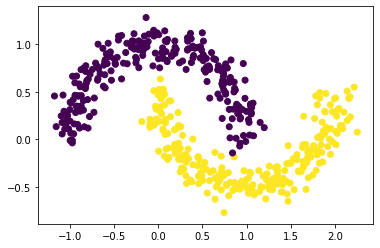

In [27]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x_blobs, y_blobs = make_moons(n_samples=500, noise=0.1)
plt.scatter(x_blobs[:,0], x_blobs[:,1], c = y_blobs)

In [28]:
X_train_blobs, X_test_blobs, y_train_blobs, y_test_blobs = train_test_split(x_blobs, y_blobs)
tree = DecisionTree(max_depth = 10, min_samples_split=1)
tree.fit(X_train_blobs, y_train_blobs)
res = tree.predict(X_test_blobs)
accuracy_score(y_test_blobs, res)

0.984

In [0]:
def build_tree(node_tree):
    dict_tree = dict()
    if node_tree.left == None:
        return {'leaf_value':node_tree.value, 'n_samples':node_tree.n_samples,
                'uniq_vals':node_tree.uniq_vals, 'entropy':node_tree.entropy}
    if node_tree.right == None:
        return {'leaf_value':node_tree.value, 'n_samples':node_tree.n_samples,
                'uniq_vals':node_tree.uniq_vals, 'entropy':node_tree.entropy}
    dict_tree = {'feature':node_tree.feature, 'n_samples':node_tree.n_samples,
                 'threshold':node_tree.threshold, 'uniq_vals':node_tree.uniq_vals,
                 'info_gain':node_tree.info_gain, 'entropy':node_tree.entropy}
    dict_tree['left'] = build_tree(node_tree.left)
    dict_tree['right'] = build_tree(node_tree.right)
    return dict_tree

In [32]:
len(X_train_blobs)

375

In [31]:
from pprint import pprint

pprint(build_tree(tree.root))

{'entropy': 0.9981474276634434,
 'feature': 1,
 'info_gain': 0.4396544441278273,
 'left': {'entropy': 0.7855602922535472,
          'feature': 0,
          'info_gain': 0.29830955116544977,
          'left': {'entropy': -0.0,
                   'leaf_value': 0,
                   'n_samples': 31,
                   'uniq_vals': 1},
          'n_samples': 256,
          'right': {'entropy': 0.5543830654157909,
                    'feature': 1,
                    'info_gain': 0.16610168410296777,
                    'left': {'entropy': -0.0,
                             'leaf_value': 1,
                             'n_samples': 124,
                             'uniq_vals': 1},
                    'n_samples': 225,
                    'right': {'entropy': 0.8649832752018336,
                              'feature': 0,
                              'info_gain': 0.27140009445115654,
                              'left': {'entropy': 0.9991983542636398,
                                     

In [33]:
from sklearn.tree import DecisionTreeClassifier

dec_tree_clf = DecisionTreeClassifier(max_depth = 10)
dec_tree_clf.fit(X_train_blobs, y_train_blobs)
res_dec_tree = dec_tree_clf.predict(X_test_blobs)
accuracy_score(y_test_blobs, res_dec_tree)

0.968